In [73]:
import numpy as np
from numpy import random
import pandas as pd
import pygraphviz as pgv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


def rule_one_possible(string):
    
    # If the last letter of the current string is I, rule 1 can be applied
    
    if string[-1:] == 'I':
        return True
    
    else:
        return False


def rule_two_possible(string):
    
    # If the first letter of the current string is M, rule 2 can be applied
    
    if string[:1] == 'M':
        return True
    else:
        return False


def rule_three_possible(string):
    
    # If the current string contains III, rule 3 can be applied
     
    if string.find('III') != -1:
        return True
    else:
        return False
    

def rule_four_possible(string):
    
    # If the current string contains UU, rule 4 can be applied
    
    if string.find('UU') != -1:
        return True
    else:
        return False    
    

def rule_three_indices(string):
    
    indices = [index for index, char in enumerate(string) if string.startswith('III', index)]

    return indices


def get_options(string):

    options = set()

    if rule_one_possible(string):
        options.add(apply_rule_one(string))

    if rule_two_possible(string):
        options.add(apply_rule_two(string))

    if rule_three_possible(string):
        for index in rule_three_indices(string):
            options.add(apply_rule_three(string, index))
        
    if rule_four_possible(string):
        options.add(apply_rule_four(string))

    return options


def get_options2(string):

    options = dict()

    if rule_one_possible(string):
        options['1'] = apply_rule_one(string)

    if rule_two_possible(string):
        options['2'] = apply_rule_two(string)

    if rule_three_possible(string):
        for index in rule_three_indices(string):
            options[f'3i{index}'] = apply_rule_three(string, index)
        
    if rule_four_possible(string):
        options['4'] = apply_rule_four(string)

    return options


def apply_rule_one(string):
    
    return string + 'U'


def apply_rule_two(string):
    
    return string + string[1:]


def apply_rule_three(string, index):
    
    return string[:index] + 'U' + string[index+3:]


def apply_rule_four(string):
    
    # the output of rule four is invariant under which index it is applied at
    
    index = string.find('II')
    
    string = string[:index] + string[index+2:]

    return string


def random_traversal(string, num_moves):
    
    path = [string]
    
    i=0
    while i < num_moves:

        options = get_options(string)
        
        string = random.choice(list(options))
        
        path.append(string)
    
        i+=1

    return path

In [59]:
allnodes = []

for i in range(100000):
    path = random_traversal('MI', 6)
    allnodes += path

allnodes = set(allnodes)
#allnodes


In [74]:
# discover entire graph for given number of available steps

current_node = 'MIII'

get_options2('MIIIIIIIIUUUUI')





{'1': 'MIIIIIIIIUUUUIU',
 '2': 'MIIIIIIIIUUUUIIIIIIIIIUUUUI',
 '3i1': 'MUIIIIIUUUUI',
 '3i2': 'MIUIIIIUUUUI',
 '3i3': 'MIIUIIIUUUUI',
 '3i4': 'MIIIUIIUUUUI',
 '3i5': 'MIIIIUIUUUUI',
 '3i6': 'MIIIIIUUUUUI',
 '4': 'MIIIIIIUUUUI'}

In [62]:
# randomly traverse the network with a given number of maximum steps. record all nodes visited in an adjacency matrix

paths=[]
adj = pd.DataFrame(0, index=list(allnodes), columns=(allnodes))

for i in range(10000):
    
    path = random_traversal('MI', 6)
    
    paths += path
    
    for first, second in zip(path, path[1:]):
        adj.loc[second, first] += 1


In [63]:
# convert all entries in adjacency matrix to 1 or 0

for column in list(adj.columns):
    adj.loc[adj[column] > 1, column] = 1

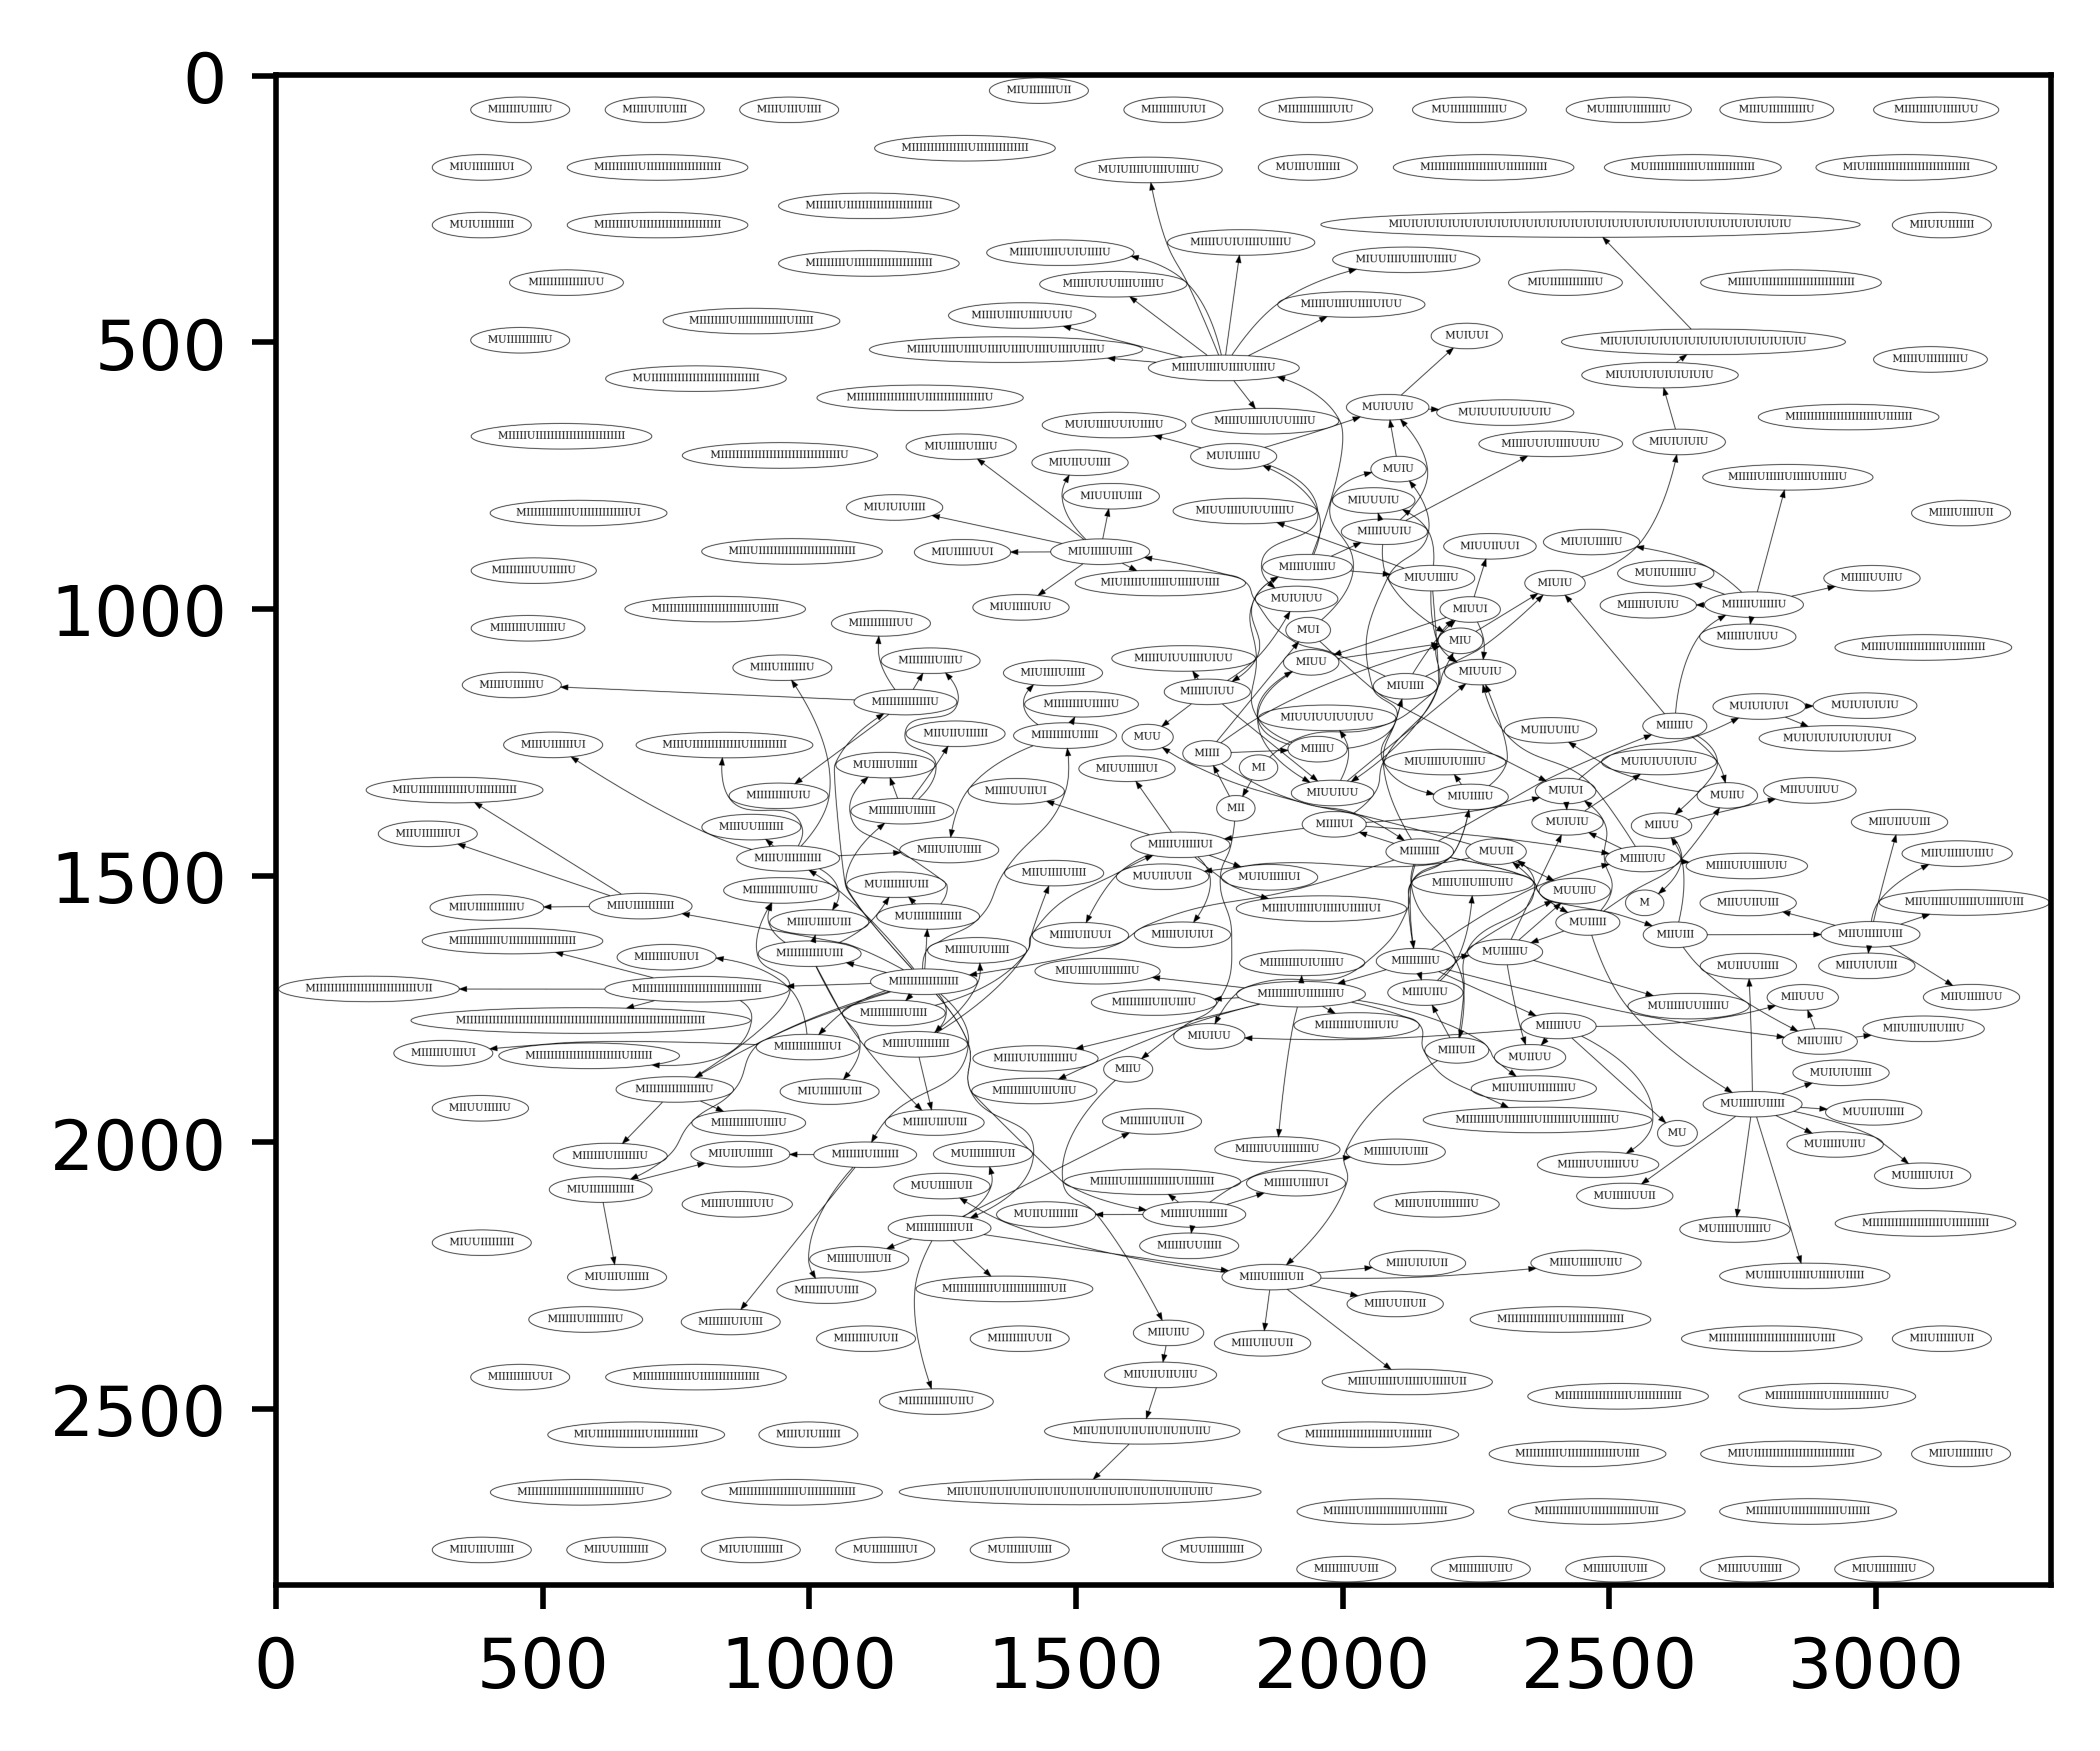

In [64]:
# plot the nodes visited in the random traversal above

plt.rcParams['figure.dpi'] = 500

dag = pgv.AGraph(directed=True, overlap='false', splines='true')

for node in adj.index:
    dag.add_node(node)

for index in adj.index:
    for child in adj.columns:
        for parent in adj.index[adj[child] == True]:
            dag.add_edge(child, parent)

dag.layout(prog='fdp')  #neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
dag.draw('dag.png')

img = mpimg.imread('dag.png')
plt.imshow(img)
plt.show()

In [108]:
dir()

['In',
 'Out',
 '_',
 '_10',
 '_100',
 '_101',
 '_102',
 '_104',
 '_105',
 '_106',
 '_107',
 '_11',
 '_15',
 '_21',
 '_22',
 '_24',
 '_26',
 '_28',
 '_31',
 '_32',
 '_35',
 '_37',
 '_38',
 '_40',
 '_42',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_5',
 '_50',
 '_51',
 '_53',
 '_54',
 '_55',
 '_57',
 '_58',
 '_59',
 '_6',
 '_61',
 '_64',
 '_66',
 '_69',
 '_73',
 '_74',
 '_75',
 '_77',
 '_78',
 '_79',
 '_8',
 '_80',
 '_82',
 '_83',
 '_84',
 '_85',
 '_86',
 '_87',
 '_88',
 '_89',
 '_90',
 '_91',
 '_92',
 '_93',
 '_94',
 '_95',
 '_96',
 '_97',
 '_98',
 '_99',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i104',
 '_i105',
 '_i106',
 '_i107',
 '_i108',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3

In [ ]:
#   
#   
#   def get_options(string):
#   
#       options = []
#   
#       if rule_one_possible(string):
#           options.append(f'apply_rule_one(string)')
#   
#       if rule_two_possible(string):
#           options.append('apply_rule_two(string)')
#   
#       if rule_three_possible(string):
#           for option in rule_three_options(string):
#               options.append(f'apply_rule_three(string, {option})')
#           
#       if rule_four_possible(string):
#           for option in rule_four_options(string):
#               options.append(f'apply_rule_four(string, {option})')
#   
#       return options
#   
#   